In [2]:
def run_query(q):
    '''function to use requests.post to make an API call to the subgraph url'''
    import requests
    # endpoint for request
    request = requests.post(f'https://gateway.thegraph.com/api/c24a3f1fcd7543ac22304ef8bf6e7157/subgraphs/id/HXfMc1jPHfFQoccWd7VMv66km75FoxVHDMvsJj5vG5vf'
                            '',
                            json={'query': q})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, q))

In [34]:
query = f"""
    {{
        totalRewards(first: 360, orderBy: block, orderDirection: desc) {{
            id
            apr
            aprBeforeFees
            aprRaw
            timeElapsed
            block
            blockTime
            transactionIndex
            totalSharesAfter
            totalSharesBefore
            totalPooledEtherAfter
            totalPooledEtherBefore
        }}
    }}
    """

In [35]:
results = run_query(query)['data']['totalRewards']
len(results)

360

In [17]:
apr = []
time = []
for result in results: 
    time.append(result.get('blockTime'))
    
    apr.append(result.get('apr'))


In [30]:
# Import lists into dataframe
import pandas as pd
df = pd.DataFrame(list(zip(time, apr)), columns =['time', 'apr'])

Now we have a dataframe with the daily `apr` rewards rate for stETH. Its current in decreasing order (i.e. newest first).

1. We can plot the APR over time to see how it has changed over time.
2. Let's find the distribution of APRs over time.

In [31]:
df

,time,apr
0,1694348543,3.45787777513325287183756176276366
1,1694262119,3.854540050468190293933599454364315
2,1694175875,3.700295840399132156961120074536638
3,1694089367,3.908104616564229726128691479217877
4,1694003279,3.975865387863542005585180941269366
...,...,...
966,1610287349,1.899658945758044025696941829646076
967,1610201867,8.732661652850100757638152526215263
968,1610180951,1.198633375968934304371166623316537
969,1610022669,34.76542748392850812257997477605544


In [32]:
# Only include APR since Merge 
post_merge = 1663253219
df['time'] = df['time'].astype(int)
df['apr'] = df['apr'].astype(float)
df = df[df['time'] > post_merge]

In [33]:
df['apr'].describe()

count    358.000000
mean       4.852996
std        1.084905
min        3.258816
25%        4.109984
50%        4.698334
75%        5.258445
max       10.207366
Name: apr, dtype: float64

Lido calculates APR using:

preShareRate = preTotalEther * 1e27 / preTotalShares
postShareRate = postTotalEther * 1e27 / postTotalShares

userAPR =
    secondsInYear * (
        (postShareRate - preShareRate) / preShareRate
    ) / timeElapsed

In [114]:
df.describe()

,time,apr,daily_rate
count,3.580000e+02,358.000000,358.000000
mean,1.678900e+09,4.852996,0.000130
std,8.980352e+06,1.084905,0.000028
min,1.663331e+09,3.258816,0.000088
25%,1.671215e+09,4.109984,0.000110
50%,1.678926e+09,4.698334,0.000126
75%,1.686638e+09,5.258445,0.000140
max,1.694349e+09,10.207366,0.000266


In [40]:
df.to_csv('data/Lido_APR.csv', index=False)

In [41]:
# Compute the daily reward rate from the annualised APR
df['daily_rate'] = (1 + df['apr'] / 100) ** (1/365) - 1

# Inspect the data with the newly added column
df.head()

/var/folders/6p/njxvnljx3b36_1d566nq5mjh0000gn/T/ipykernel_24752/422795172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daily_rate'] = (1 + df['apr'] / 100) ** (1/365) - 1


,time,apr,daily_rate
0,1694348543,3.457878,0.000093
1,1694262119,3.854540,0.000104
2,1694175875,3.700296,0.000100
3,1694089367,3.908105,0.000105
4,1694003279,3.975865,0.000107


Weekly Window Analysis

We'll group the daily rates into weekly windows and compute the weekly reward rates. After that, we can analyse the distribution of these weekly rates.

Grouping Data: We'll group the daily rates into weekly windows. Since the data has timestamps in decreasing order (looking back in time), we'll create weekly windows based on the number of rows rather than using the actual timestamps.
Computing Weekly Rates: We'll compute the weekly rates by taking the difference between the first and last daily rates in the weekly window.

Once we have the weekly rates, we'll analyse the distribution to understand the variability and central tendencies of the weekly reward rates.

In [42]:
# Group data into weekly windows and compute the weekly reward rates
weekly_rates = []

# Since the data is in decreasing order, we'll use a negative step size for our iteration
for i in range(0, len(df) - 6, 7):
    weekly_data = df.iloc[i:i+7]
    weekly_rate = (1 + weekly_data['daily_rate']).prod() - 1  # Compute the compound weekly rate
    weekly_rates.append(weekly_rate)

# Convert the list of weekly rates into a pandas Series for analysis
weekly_rates_series = pd.Series(weekly_rates)

weekly_rates_series.describe()

count    51.000000
mean      0.000908
std       0.000146
min       0.000702
25%       0.000778
50%       0.000907
75%       0.000990
max       0.001344
dtype: float64

Count: There are 51 weekly windows in the dataset. \
Mean: The average weekly reward rate is approximately 0.0908% \
Standard Deviation: The standard deviation is approximately 0.0146%, indicating the variability of the weekly rates around the mean.\
Minimum: The lowest weekly reward rate observed is approximately 0.0702%.\
25th Percentile: 25% of the weekly rates are below approximately 0.0778%. \
Median (50th Percentile): The median weekly reward rate is approximately 0.0907%. \
75th Percentile: 75% of the weekly rates are below approximately 0.0990%. \
Maximum: The highest weekly reward rate observed is approximately 0.1344%. \
This descriptive summary provides insights into the central tendency and variability of the weekly reward rates. 

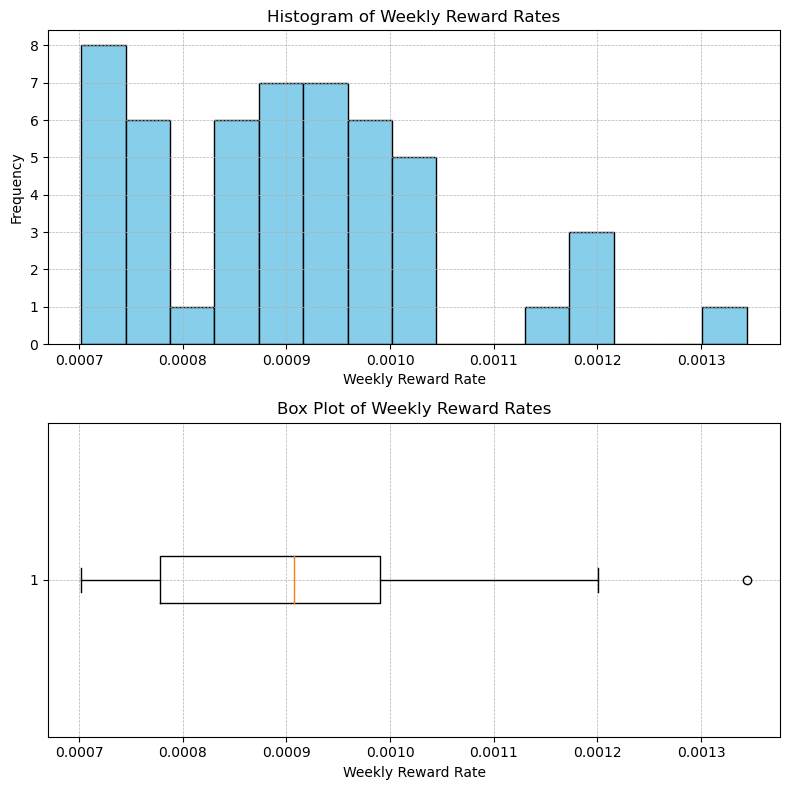

In [48]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# Histogram for weekly rates
ax[0].hist(weekly_rates_series, bins=15, color='skyblue', edgecolor='black')
ax[0].set_title('Histogram of Weekly Reward Rates')
ax[0].set_xlabel('Weekly Reward Rate')
ax[0].set_ylabel('Frequency')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Box plot for weekly rates
ax[1].boxplot(weekly_rates_series, vert=False)
ax[1].set_title('Box Plot of Weekly Reward Rates')
ax[1].set_xlabel('Weekly Reward Rate')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()


---

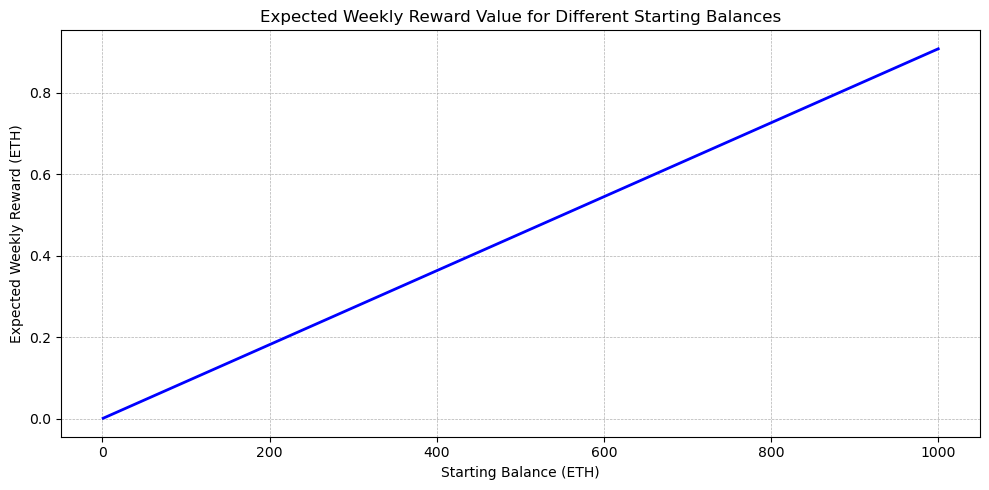

In [50]:
# Compute mean weekly rate
mean_weekly_rate = weekly_rates_series.mean()

# Define a range of starting balances from 1 to 1000 ETH
starting_balances = range(1, 1001)

# Compute expected weekly rewards for each starting balance
expected_rewards = [balance * mean_weekly_rate for balance in starting_balances]

# Create the chart
plt.figure(figsize=(10, 5))
plt.plot(starting_balances, expected_rewards, color='blue', linewidth=2)
plt.xlabel('Starting Balance (ETH)')
plt.ylabel('Expected Weekly Reward (ETH)')
plt.title('Expected Weekly Reward Value for Different Starting Balances')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


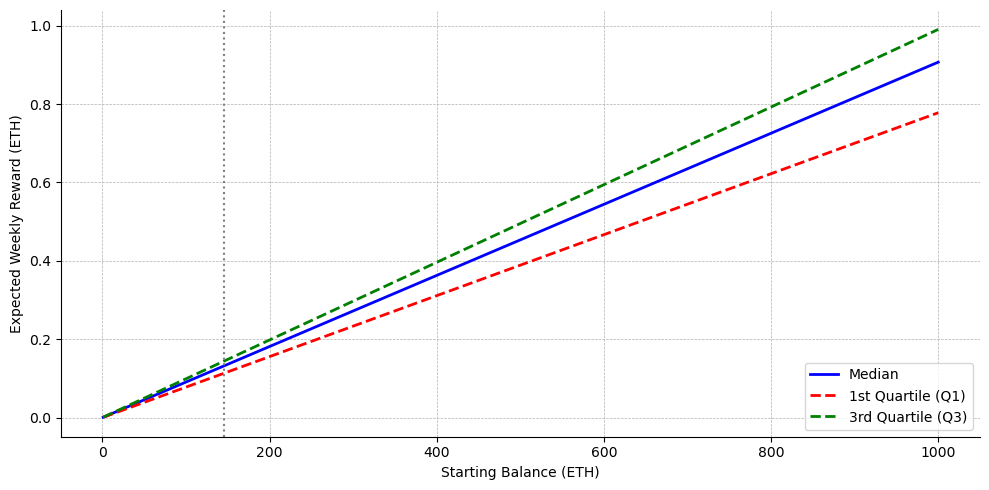

In [64]:
# Compute median, 1st quartile (Q1), and 3rd quartile (Q3) of the weekly reward rates
median_weekly_rate = weekly_rates_series.median()
q1_weekly_rate = weekly_rates_series.quantile(0.25)
q3_weekly_rate = weekly_rates_series.quantile(0.75)

# Compute expected weekly rewards for each starting balance using the median, Q1, and Q3 rates
expected_rewards_median = [balance * median_weekly_rate for balance in starting_balances]
expected_rewards_q1 = [balance * q1_weekly_rate for balance in starting_balances]
expected_rewards_q3 = [balance * q3_weekly_rate for balance in starting_balances]

# Create the chart
plt.figure(figsize=(10, 5))
plt.plot(starting_balances, expected_rewards_median, color='blue', linewidth=2, label='Median')
plt.plot(starting_balances, expected_rewards_q1, color='red', linewidth=2, linestyle='--', label='1st Quartile (Q1)')
plt.plot(starting_balances, expected_rewards_q3, color='green', linewidth=2, linestyle='--', label='3rd Quartile (Q3)')
plt.axvline(x=145, color='grey', linestyle=':', linewidth=1.5)  # Line at difference of 0
plt.xlabel('Starting Balance (ETH)')
plt.ylabel('Expected Weekly Reward (ETH)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

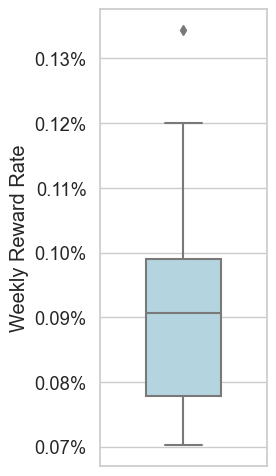

In [103]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Create the box plot with y-axis in percentage format
plt.figure(figsize=(3, 5))
sns.boxplot(y=weekly_rates_series, color='lightblue', width=0.45)

# Format y-axis as percentage
formatter = FuncFormatter(lambda y, _: '{:.2%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel('Weekly Reward Rate')
plt.tight_layout()
file_path = 'charts/rafflePrizeDistribution.png'
plt.savefig(file_path)
plt.show()

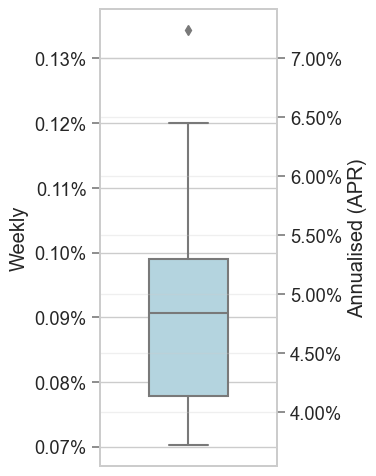

In [113]:
# Create the box plot with dual y-axis (weekly rate and corresponding APR)
fig, ax1 = plt.subplots(figsize=(4, 5))

# Left y-axis for weekly rate
sns.boxplot(y=weekly_rates_series, color='lightblue', width=0.45, ax=ax1, zorder=2)
ax1.set_ylabel('Weekly')
ax1.yaxis.set_major_formatter(formatter)
ax1.tick_params(axis='y', color='grey')

# Create and set up the right y-axis for APR
ax2 = ax1.twinx()
# Set the limits of the right y-axis based on the left y-axis
ax2.set_ylim([(1 + val) ** 52 - 1 for val in ax1.get_ylim()])
# Format right y-axis as percentage
ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylabel('Annualised (APR)')
# Reduce opacity and set a lower zorder for the right axis grid lines
ax2.grid(alpha=0.3, zorder=1)
ax2.tick_params(axis='y', color='grey')
plt.tight_layout()

file_path = 'charts/rafflePrizeDistribution.png'
plt.savefig(file_path)
plt.show()

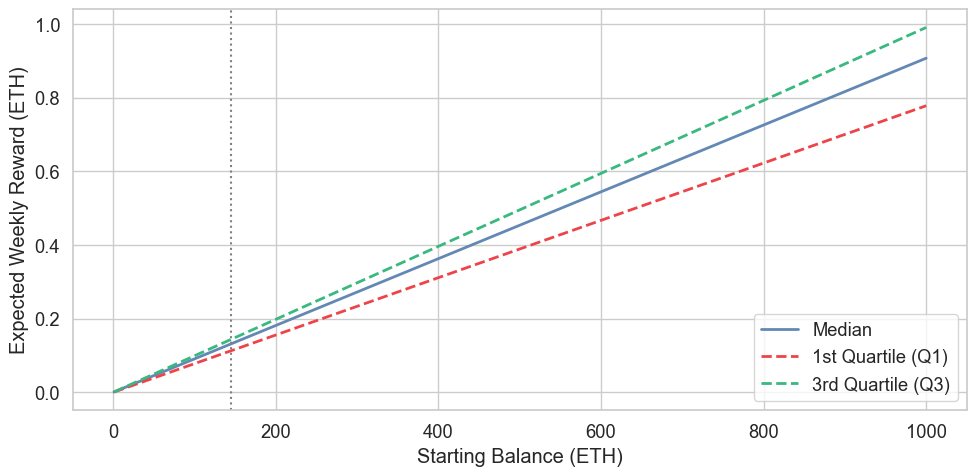

In [102]:
# Set the context with a larger font scale
sns.set_context("notebook", font_scale=1.2)
# Create the three-line chart using seaborn
plt.figure(figsize=(10, 5))

# Plot the lines for Median, Q1, and Q3
sns.lineplot(x=starting_balances, y=expected_rewards_median, label='Median', color='#6388b4', linewidth=2)
sns.lineplot(x=starting_balances, y=expected_rewards_q1, label='1st Quartile (Q1)', color='#ed444a', linestyle='--', linewidth=2)
sns.lineplot(x=starting_balances, y=expected_rewards_q3, label='3rd Quartile (Q3)', color='#39b87f', linestyle='--', linewidth=2)

# Add a vertical dotted line at x=145
plt.axvline(x=145, color='grey', linestyle=':', linewidth=1.5)

# Set labels and title
plt.xlabel('Starting Balance (ETH)')
plt.ylabel('Expected Weekly Reward (ETH)')
plt.tight_layout()
file_path = 'charts/raffleExpectedPrize.png'
plt.savefig(file_path)
plt.show()